In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the file of contestant data
file_path = '/Users/ginagrainda/Desktop/survivor_data/survivor_contestants_encoded.csv'
data = pd.read_csv(file_path)

In [56]:
# Split out Season 47 data and save it to a csv and excel
season_47_data = data[data['num_season'] == 47]
season_47_path = '/Users/ginagrainda/Desktop/survivor_data/survivor_season_47.csv'
season_47_data.to_csv(season_47_path, index=False)
season_47_excel_path = '/Users/ginagrainda/Desktop/survivor_data/survivor_season_47.xlsx'
season_47_data.to_excel(season_47_excel_path, index=False)

# Keep the rest of the data to train on 
data = data[data['num_season'] != 47]

In [57]:
features = data.drop(columns=['contestant_name', 'age', 'hometown', 'profession','country', 'birthdate', 
                              'num_boot', 'initial-tribe','industry', 'gender', 'state', 'region', 
                              'astrological_sign', 'tribe_color', 'age_band', 'num_season', 'finish'], inplace=False)

In [58]:
# Correlations shows how two variables move in relation to one another. 
    # It ranges between -1 and 1, with a value of 0 indicating no correlation
correlation_matrix = features.corr()

# Look for the correlations with the winner 
winner_correlations = correlation_matrix['winner']
sorted_winner_correlations = winner_correlations.sort_values(ascending=False)
top_25_correlations = sorted_winner_correlations.head(25)
print(top_25_correlations)

winner                                        1.000000
region_Caribbean                              0.143429
industry_Business, Finance, Administrative    0.102884
region_Canada                                 0.093032
astrological_sign_Capricorn                   0.088584
industry_Retail and Consumer Services         0.076846
gender_M                                      0.041600
region_Northeast                              0.040264
industry_Law, Public Safety, Military         0.030647
astrological_sign_Cancer                      0.027639
age_band_26-35                                0.027471
astrological_sign_Leo                         0.025623
num_appearance                                0.024788
latinx                                        0.024399
jewish                                        0.023078
age_band_18-25                                0.021451
industry_Nonprofit, Social, Religious         0.019379
tribe_color_Pink                              0.018269
white     

In [9]:
# Correlations measure linear relationships
    # Looking at the correlation values & heatmap, there are low correlations between winner and the features
    # The features (hopefully) have non-linear relationships, and the predictive power can't be measured with correlations
    # During modeling, it will be important to use an non-linear model (ex. xgboost or random forest)

In [60]:
# Feature engineering!
# Create interaction features to enhance predictive 
data['gender_man_and_region_West'] = data['gender_M'] * data['region_West'] # men from West have a higher chance of winning
data['gender_woman_and_age_26_35'] = data['gender_F'] * data['age_band_26-35'] # women who are between ages 26-35 have a better chance of winning
data['poc_and_age_26_35'] = data['poc'] * data['age_band_26-35'] # contestants who are people of color (POC) and are ages 26-35 when they play have a higher chance of winning
data['gender_woman_and_new_era_season'] = data['gender_F'] * data['new_era_season'] # women in the new era have a better chance of winning
data['tribe_blue_and_capricorn'] = data['tribe_color_Blue'] * data['astrological_sign_Capricorn'] # fun feature! Contestants whose astrological sign is Capricorn and have an initial tribe color of blue have a higher chance of winning

print(data[['gender_man_and_region_West', 'gender_woman_and_age_26_35', 
            'poc_and_age_26_35', 'gender_woman_and_new_era_season', 'tribe_blue_and_capricorn']].head())

   gender_man_and_region_West  gender_woman_and_age_26_35  poc_and_age_26_35  \
0                           0                           0                  0   
1                           0                           0                  0   
2                           0                           1                  0   
3                           0                           1                  1   
4                           0                           0                  0   

   gender_woman_and_new_era_season  tribe_blue_and_capricorn  
0                                0                         0  
1                                0                         0  
2                                0                         0  
3                                0                         0  
4                                0                         0  


In [63]:
# Define features (X) and target (y)
X = data[['gender_M',
          'industry_Law, Public Safety, Military',
          'industry_Business, Finance, Administrative',
          'industry_Arts, Media, Entertainment',
          'industry_Advertising, Marketing, Sales',
          'region_Northeast',
          'region_West',
          'age_band_26-35',
          'tribe_color_Blue',
          'tribe_color_Yellow',
        # Interaction features
          'gender_man_and_region_West', 
          'gender_woman_and_age_26_35',
          'poc_and_age_26_35', 
          'gender_woman_and_new_era_season',
          'tribe_blue_and_capricorn']]
y = data['winner']  # Target column 

In [64]:
# Split data into 80% training and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (671, 15)
Testing size: (168, 15)


In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Train the xgboost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

In [66]:
# Accuracy score - proportion of correct predictions; indicates how well the model performs overall
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# AUC-ROC score - model's ability to rank positive (winners) higher than negative (non-winners)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.94
AUC-ROC: 0.43


In [67]:
# AUC-ROC is lower than 0.5, which is worse than random guessing
# Data is very imbalanced, as there are significantly more non-winners than winners
# To address this, I am going to "upsample"; this means duplicate the winners to match the non-winners and balance the data set
from sklearn.utils import resample
import pandas as pd

# Combine features (X) and target (y) for resampling
data_resampled = pd.concat([X, y], axis=1)

# Separate majority and minority classes
winners = data_resampled[data_resampled['winner'] == 1]
non_winners = data_resampled[data_resampled['winner'] == 0]

# Upsample the minority class (winners)
winners_upsampled = resample(winners, replace=True, n_samples=len(non_winners), random_state=42)

# Combine majority class with the upsampled minority class
data_balanced = pd.concat([non_winners, winners_upsampled])

# Split back into X and y
X_balanced = data_balanced.drop(columns=['winner'])
y_balanced = data_balanced['winner']
print(y_balanced.value_counts())

winner
0.0    793
1.0    793
Name: count, dtype: int64


In [68]:
# Split data into 80% training and 20% testing again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Training size: (1268, 15)
Test size: (318, 15)


In [69]:
# Re-train the model
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [70]:
# Re-evaluate model performance after upsampling
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}") # model correctly predicts winners and non-winners 83% of the time
print(f"AUC-ROC: {roc_auc:.2f}") # model effectively distinguishes between winners and non-winners

Accuracy: 0.85
AUC-ROC: 0.92


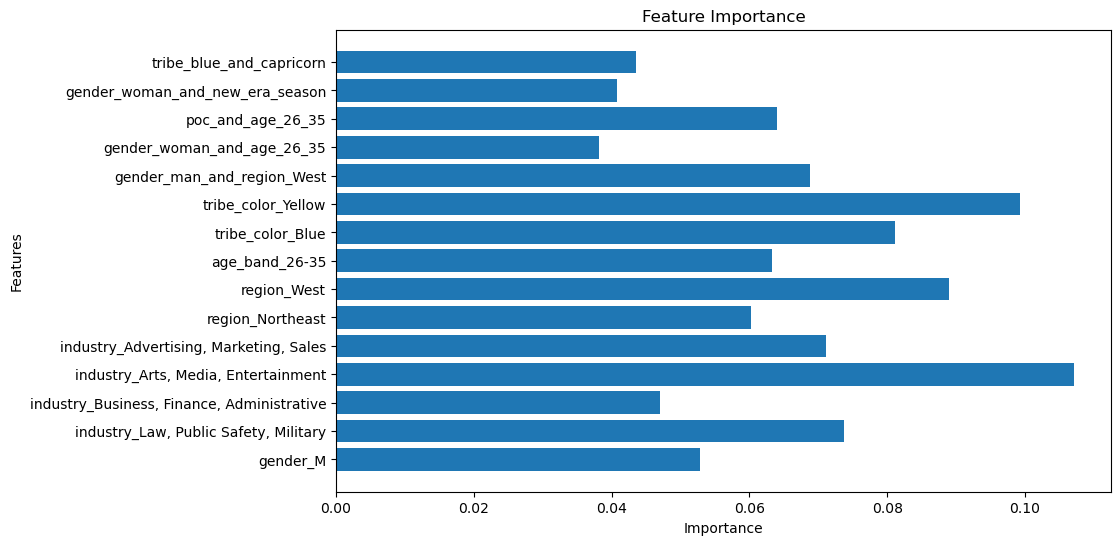

In [71]:
# Evaluate feature importance
feature_importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_balanced.columns, feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [72]:
import pickle

file_path = '/Users/ginagrainda/Desktop/survivor_data/survivor_winner_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(xgb_model, file)

print(f"Model saved successfully!")

Model saved successfully!
